In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

from data.prepare_data import *
from data.prepare_word2vec_ed import *
from similarities.text_similarities import levenshtein_similarity, levenshtein_similarity_with_threshold

In [28]:
ps_data = get_ps_data()
model = Word2Vec.load('utils/word2vec.model')

slovab = {'name':'vyjmenovane_slova_b', 'data': get_vyjmenovana_slova_po_b(ps_data)}
koncprid = {'name':'koncovky_prid_jmena', 'data': get_data_by_knowledge_component(ps_data, 36)}
datasets = [slovab, koncprid]

#### Change the dataset below for another concept

In [43]:
dataset = datasets[0]

In [44]:
X, data = get_word2vec_items(model, dataset['data'])
# some questions with same text are labeled in more question_ids
data.sort_values(['question_id'], inplace=True)
data.drop_duplicates(['question'], inplace=True)

### Computation of similarity matrix for Pearson and DoublePearson

In [45]:
# get only the not duplicated data that are in our word2vec model
filtered = dataset['data'].loc[dataset['data']['question_id'].isin(data['question_id'])]
correctness_matrix = reshape_to_correctness_matrix(filtered)
doublepearson = correctness_matrix_to_similarity_matrix('doublepearson', correctness_matrix)
pearson = correctness_matrix_to_similarity_matrix('pearson', correctness_matrix)

In [46]:
if sorted(pearson.columns.tolist()) == sorted(data['question_id'].tolist()):
    print('Well filtered')

Well filtered


### Computation of similarity matrix for Edit distance and Word2vec

In [47]:
print('Computing similarity matrix based on Edit distance')
editdistance = create_edit_similarity_matrix(data['question_id'], data['solution'], levenshtein_similarity)

Computing similarity matrix based on Edit distance


In [48]:
print('Computing similarity matrix based on Word2vec')
word2vec = create_word2vec_similarity_matrix(model, data['question_id'], data['solution'])

Computing similarity matrix based on Word2vec


In [49]:
pearson.index.tolist() == doublepearson.index.tolist()

True

In [50]:
editdistance.index.tolist() == doublepearson.index.tolist()

True

In [51]:
word2vec.index.tolist() == doublepearson.index.tolist()

True

### Compututation of similarity matrix for Edit distance with a threshold

In [52]:
dataframes = []

In [53]:
for m in [4,6,8]:
    print('Computing sim matrix for edit distance with threshold ' + str(m))
    dataframe = pd.DataFrame(index=data['question_id'],columns=data['question_id'])
    for i, j in zip(data['solution'], data['question_id']):
        for k, l in zip(data['solution'], data['question_id']):
                dataframe.loc[j, l] = levenshtein_similarity_with_threshold(i, k, M=m)
    dataframes.append(dataframe)

Computing sim matrix for edit distance with threshold 4
Computing sim matrix for edit distance with threshold 6
Computing sim matrix for edit distance with threshold 8


In [57]:
values = pd.DataFrame()
values['defaultED'] = editdistance.values.flatten().astype(float)
values['ED with M=4'] = dataframes[0].values.flatten().astype(float)
values['ED with M=6'] = dataframes[1].values.flatten().astype(float)
values['ED with M=8'] = dataframes[2].values.flatten().astype(float)
values['word2vec'] = word2vec.values.flatten().astype(float)
values['dpearson'] = doublepearson.values.flatten()
values['pearson'] = pearson.values.flatten()
correlations = values.corr()
if dataset['name'] == 'vyjmenovane_slova_b':
    datasets[0]['correlations'] = correlations
else:
    datasets[1]['correlations'] = correlations

# Correlations, Heatmap

Heatmap below is for concept Vyjmenovane slova B

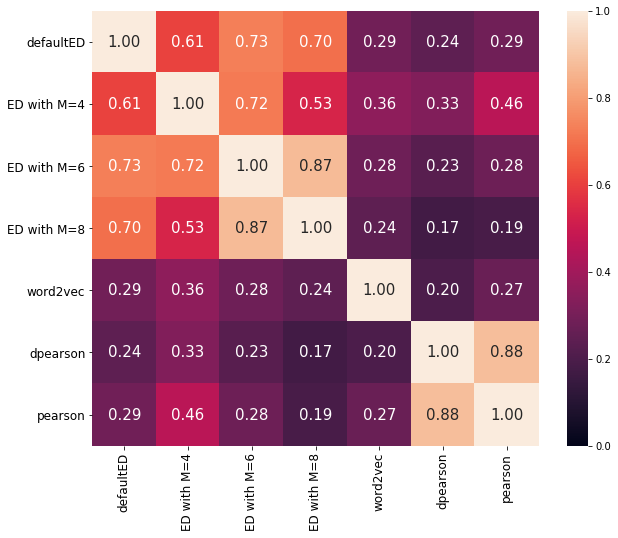

In [60]:
sns.heatmap(correlations, annot=True, fmt=".2f", annot_kws={"size": 15}, vmin=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gcf().set_size_inches(10, 8)
# plt.savefig('visualizations/seaborn/heatmap-correlations-lev_threshold-%s.svg' % dataset['name'])
plt.show()

## Visualizing both heatmaps of two knowledge componentss

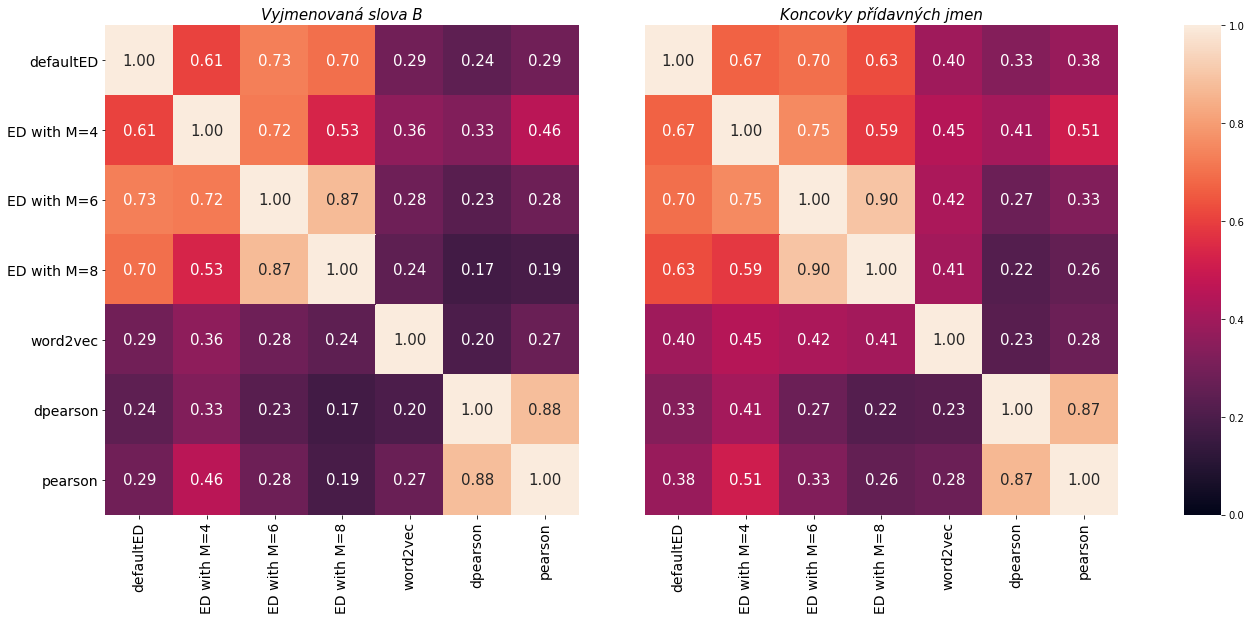

In [61]:
figure, (ax1,ax2, axcb) = plt.subplots(1,3, gridspec_kw={'width_ratios':[1,1,0.08]})
figure.set_size_inches(20,9)
ax1.get_shared_y_axes().join(ax2)
a1 = sns.heatmap(datasets[0]['correlations'], ax=ax1, cbar=False, annot=True, annot_kws={"size": 15}, fmt=".2f", vmin=0)
a1.set_ylabel('')
a1.set_xlabel('')
a1.set_title('Vyjmenovaná slova B', fontsize=15, fontstyle='italic')

a2 = sns.heatmap(datasets[1]['correlations'], ax=ax2, cbar_ax=axcb, annot=True, annot_kws={"size": 15}, fmt=".2f", vmin=0)
a2.set_ylabel('')
a2.set_xlabel('')
a2.set_yticks([])
a2.set_title('Koncovky přídavných jmen', fontsize=15, fontstyle='italic')

for ax in [a1, a2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90, fontsize=14)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0, fontsize=14)

# plt.savefig('visualizations/seaborn/heatmap-correlations.svg')
plt.show()